In [1]:
import torch
import torch.nn as nn
import os
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt

In [2]:
def activation(name):
    if name in ['tanh', 'Tanh']:
        return nn.Tanh()
    elif name in ['relu', 'ReLU']:
        return nn.ReLU(inplace=True)
    elif name in ['lrelu', 'LReLU']:
        return nn.LeakyReLU(inplace=True)
    elif name in ['sigmoid', 'Sigmoid']:
        return nn.Sigmoid()
    elif name in ['softplus', 'Softplus']:
        return nn.Softplus(beta=4)
    elif name in ['celu', 'CeLU']:
        return nn.CELU()
    elif name in ['elu']:
        return nn.ELU()
    elif name in ['mish']:
        return nn.Mish()
    else:
        raise ValueError('Unknown activation function')




################################################################
#  1d fourier layer
################################################################
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)


    def forward(self, x):
        """
        # x.shape == [batch_size, in_channels, number of grid points]
        # hint: use torch.fft library torch.fft.rfft
        # use DFT to approximate the fourier transform
        batch_size, in_channels, n_gp = x.shape
        x = torch.fft.rfft(x.float(), dim=fft_dims)
        
        # Compute Fourier coefficients
        out_fft = torch.zeros([batch_size, self.out_channels, self.modes1] dtype=torch.cfloat)
        
        # Multiply relevant Fourier modes
        
        # Return to physical space
        return x
        """
        batch_size, in_channels, n_gp = x.shape
        # Fourier transformation
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes -- see numpy documentation for rfft output size (Hermitian)
        out_ft = torch.zeros(batch_size, self.out_channels, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        #Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x


####################################################################


class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes1 = modes
        self.width = width
        self.padding = 1  # pad the domain if input is non-periodic
        self.linear_p = nn.Linear(2, self.width)  # input channel is 2: (u0(x), x)

        self.spect1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.lin0 = nn.Conv1d(self.width, self.width, 1)
        self.lin1 = nn.Conv1d(self.width, self.width, 1)
        self.lin2 = nn.Conv1d(self.width, self.width, 1)

        self.linear_q = nn.Linear(self.width, 32)
        self.output_layer = nn.Linear(32, 1)

        self.activation = torch.nn.Tanh()

    def fourier_layer(self, x, spectral_layer, conv_layer):
        return self.activation(spectral_layer(x) + conv_layer(x))

    def linear_layer(self, x, linear_transformation):
        return self.activation(linear_transformation(x))

    def forward(self, x):
        # grid = self.get_grid(x.shape, x.device)
        # x = torch.cat((x, grid), dim=-1)
        x = self.linear_p(x)
        x = x.permute(0, 2, 1)
        # x = F.pad(x, [0, self.padding])  # pad the domain if input is non-periodic

        x = self.fourier_layer(x, self.spect1, self.lin0)
        x = self.fourier_layer(x, self.spect2, self.lin1)
        x = self.fourier_layer(x, self.spect3, self.lin2)

        # x = x[..., :-self.padding]  # pad the domain if input is non-periodic
        x = x.permute(0, 2, 1)

        x = self.linear_layer(x, self.linear_q)
        x = self.output_layer(x)
        return x


In [8]:
torch.manual_seed(0)
np.random.seed(0)

n_train =100

x_data = torch.from_numpy(np.load("AC_data_input.npy")).type(torch.float32)
y_data = torch.from_numpy(np.load("AC_data_output.npy")).type(torch.float32)


temporary_tensor = torch.clone(x_data[:, :, 0])
x_data[:, :, 0] = x_data[:, :, 1]
x_data[:, :, 1] = temporary_tensor


input_function_train = x_data[:n_train, :]
output_function_train = y_data[:n_train, :]
input_function_test = x_data[n_train:, :]
output_function_test = y_data[n_train:, :]

print(f"{input_function_train.shape=}")
print(f"{output_function_train.shape=}")

batch_size = 10

training_set = DataLoader(TensorDataset(input_function_train, output_function_train), batch_size=batch_size, shuffle=True)
testing_set = DataLoader(TensorDataset(input_function_test, output_function_test), batch_size=batch_size, shuffle=False)

input_function_train.shape=torch.Size([100, 1001, 2])
output_function_train.shape=torch.Size([100, 1001])


In [4]:
learning_rate = 0.001

# epochs = 250
epochs = 10
step_size = 50
gamma = 0.5

modes = 16
width = 64

# model

fno = FNO1d(modes, width)

In [5]:
optimizer = Adam(fno.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

l = torch.nn.MSELoss()
freq_print = 1
for epoch in range(epochs):
    train_mse = 0.0
    for step, (input_batch, output_batch) in enumerate(training_set):
        optimizer.zero_grad()
        output_pred_batch = fno(input_batch).squeeze(2)
        loss_f = l(output_pred_batch, output_batch)
        loss_f.backward()
        optimizer.step()
        train_mse += loss_f.item()
    train_mse /= len(training_set)

    scheduler.step()

    with torch.no_grad():
        fno.eval()
        test_relative_l2 = 0.0
        for step, (input_batch, output_batch) in enumerate(testing_set):
            output_pred_batch = fno(input_batch).squeeze(2)
            loss_f = (torch.mean((output_pred_batch - output_batch) ** 2) / torch.mean(output_batch ** 2)) ** 0.5 * 100
            test_relative_l2 += loss_f.item()
        test_relative_l2 /= len(testing_set)

    if epoch % freq_print == 0: print("######### Epoch:", epoch, " ######### Train Loss:", train_mse, " ######### Relative L2 Test Norm:", test_relative_l2)


######### Epoch: 0  ######### Train Loss: 0.3041863705962896  ######### Relative L2 Test Norm: 38.9784880956014
######### Epoch: 1  ######### Train Loss: 0.06348589975386858  ######### Relative L2 Test Norm: 24.926398118336994
######### Epoch: 2  ######### Train Loss: 0.03617080915719271  ######### Relative L2 Test Norm: 16.51577860514323
######### Epoch: 3  ######### Train Loss: 0.016960201598703862  ######### Relative L2 Test Norm: 13.224725739161174
######### Epoch: 4  ######### Train Loss: 0.013662099093198776  ######### Relative L2 Test Norm: 11.714264482922024
######### Epoch: 5  ######### Train Loss: 0.008291580225341022  ######### Relative L2 Test Norm: 10.766490326987373
######### Epoch: 6  ######### Train Loss: 0.007858116668649018  ######### Relative L2 Test Norm: 10.443440055847168
######### Epoch: 7  ######### Train Loss: 0.0076524644624441866  ######### Relative L2 Test Norm: 9.872487264209324
######### Epoch: 8  ######### Train Loss: 0.0050447248620912434  ######### Rela

torch.Size([1, 1001, 2])
torch.Size([1, 1001])
torch.Size([1, 1001, 1])
tensor([-1.0000, -0.9980, -0.9960,  ...,  0.9960,  0.9980,  1.0000])
Relative L2 error:  2.9532182216644287


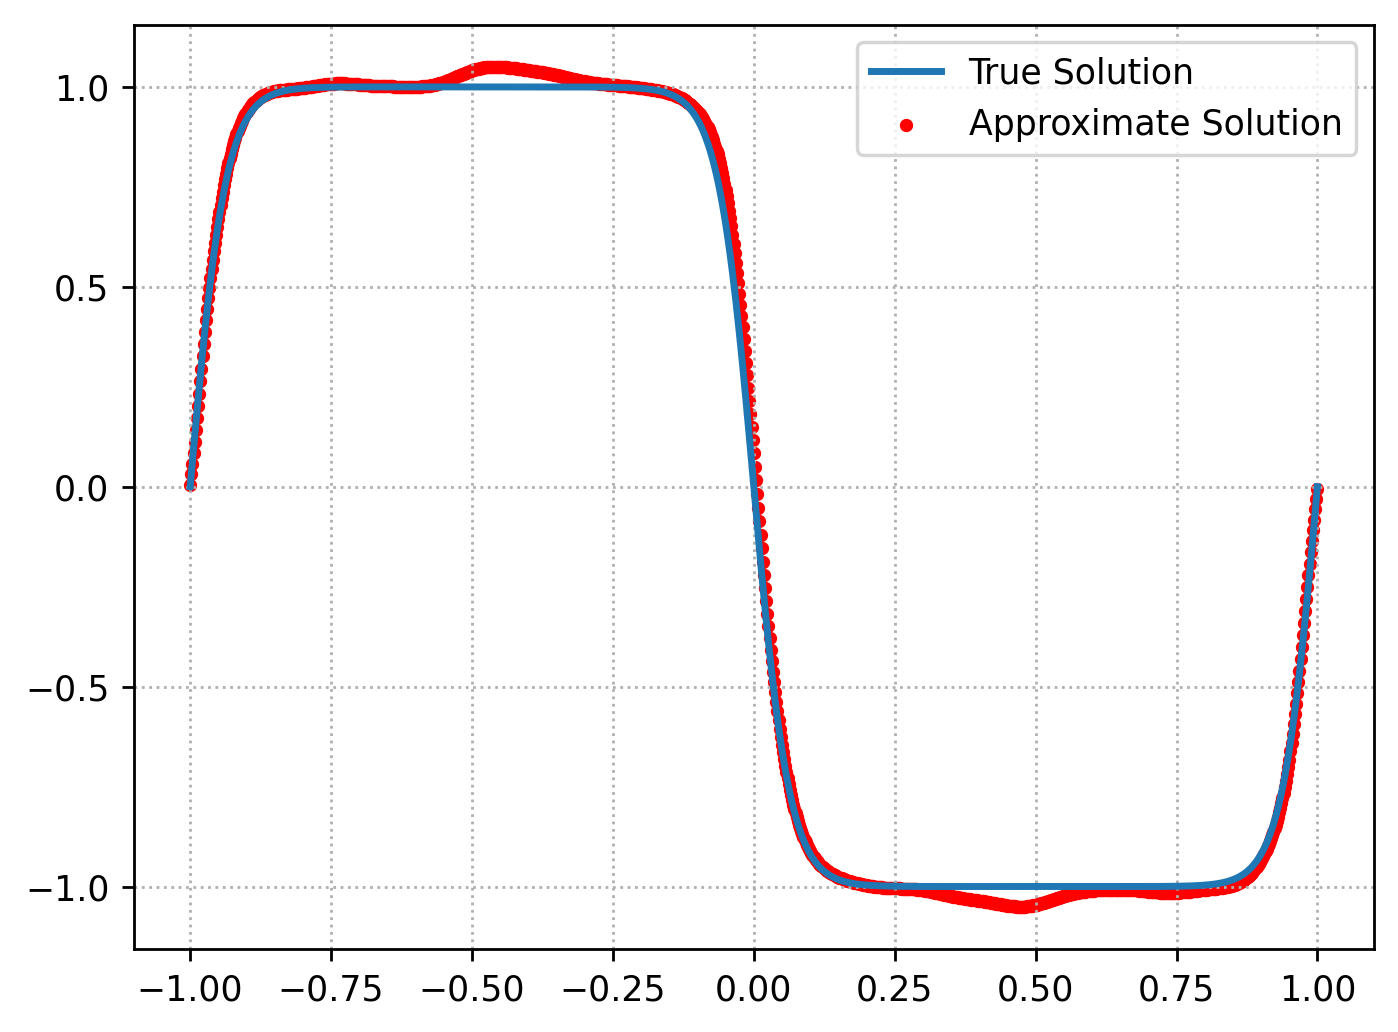

In [6]:
idx_data = 134
input_function_test_n = input_function_test[idx_data, :].unsqueeze(0)
output_function_test_n = output_function_test[idx_data, :].unsqueeze(0)
print(input_function_test_n.shape)
print(output_function_test_n.shape)

output_function_test_pred_n = fno(input_function_test_n)
print(output_function_test_pred_n.shape)
print(input_function_test_n[0,:,1])
plt.figure(dpi=250)
plt.grid(True, which="both", ls=":")
plt.plot(input_function_test_n[0,:,1].detach(), output_function_test_n[0].detach(), label="True Solution", c="C0", lw=2)
plt.scatter(input_function_test_n[0,:,1].detach(), output_function_test_pred_n[0].detach(), label="Approximate Solution", s=8, c="red")
p = 2
err = (torch.mean(abs(output_function_test_n.detach().reshape(-1, ) - output_function_test_pred_n.detach().reshape(-1, )) ** p) / torch.mean(abs(output_function_test_n.detach()) ** p)) ** (1 / p) * 100
print("Relative L2 error: ", err.item())
plt.legend()

In [ ]:
######################### TO DO ####################################
# evaluate drop in performance when the skip connection is removed
# aka the " + conv_layer(x)"
####################################################################